### Artificial Data
---

* Special input values
* Regular values
* Out of range
* Missing value

In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import random 

import sys
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
# from train import features, preprocess, encode_defaults, default_values
from src.utils import scale_scores
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

In [34]:
from collections import defaultdict

def encode_defaults(df, default_values):
    """Replace default values with NaN, int encode them"""
    default_encoded_cols = []
    for k, (v, encode) in default_values.items():
        cname = k + '_default_encoded'

        if isinstance(v, pd.Interval):
            is_default = ~df[k].between(v.left, v.right) & ~df[k].isna()
        elif isinstance(v, list):
            is_default = df[k].isin(k)
        else:
            raise RuntimeError('Data type {} not supported'.format(str(type(v))))
        
        if ~is_default.isna().all():
            if encode:
                default_encoded_cols.append(cname)
                df.loc[is_default, cname] = is_default * df[k]
            df.loc[is_default, k] = np.nan #set default values to NaN
        
    return df, default_encoded_cols


cols_raw = ['first_deposit_amount', 'vantage_score', 'bcc7120', 'email_risk_score', 
            'fraud_score_2', 'name_email_correlation', 'transaction_as_pct_of_balance', 
            'mean_account_balance_30d', 'phone_risk_score', 
            'name_address_correlation', 'all8220', 'lag_acc_open_first_transaction', 
            'dollar_val_dd', 'all7120', 'sum_deposits_10d', 'nr_past_transactions', 
            'total_tradelines_open', 'education_loan_amount', 'address_risk_score',
            'iqt9415', 'max_withdrawals_30d', 'iln5520', 'max_deposits_30d', 
            'pct_returned_deposits', 'giact_nr_decline', 'nr_direct_deposits', 
            'time_since_last_transaction', 'bal_ratio', 'name_phone_correlation', 
            'giact_nr_other', 'dollar_val_returns', 'nr_trans_ratio', 'iqt9413', 
            'dollar_val_returns_3d', 'nr_returns_30d', 'credit_card_loan_amount',
            'fraud_score_1', 'age_money_account']

cols_raw_ni = ['transaction_code']

cols_encoded = ['transaction_code_encoded', 'all7120_default_encoded', 'bcc7120_default_encoded']

features = cols_raw + cols_encoded

default_values = {
    'vantage_score': [pd.Interval(300, 850), False],
    'all7120': [pd.Interval(0, 990), True],
    'all8220': [pd.Interval(0, 9990), False],
    'bcc7120': [pd.Interval(0, 990), True],
    'iln5520': [pd.Interval(0, 999999990), False],
    'iqt9413': [pd.Interval(0, 90), False]
}

def preprocess(df):
    """
    Code to preprocess model.
    """
    # mapping from transaction code to integer
    tcode_map = defaultdict(int,
                            {'POSDW': 1,
                             'ACHDD': 2,
                             'ACHDWIN': 3,
                             'ACHDDIN': 4,
                             'ACHDW': 5,
                             'ACHINDD': 6,
                             'DDATMREFUND': 7,
                             'DWATM': 8,
                             'DDRAFNEW':9,
                             'DDCK': 10})

    df['transaction_code_encoded'] = df['transaction_code'].map(tcode_map)
    
    # clip to handle infinite values and outliers
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].clip(-750, 750)
    df['bal_ratio'] = df['bal_ratio'].clip(-750, 750)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].clip(0, 100)

    # fill na here with 0, can't be NaN just indicates lack of data
    df['transaction_as_pct_of_balance'] = df['transaction_as_pct_of_balance'].fillna(0)
    df['max_withdrawals_30d'] = df['max_withdrawals_30d'].fillna(0)
    df['max_deposits_30d'] = df['max_deposits_30d'].fillna(0)
    df['pct_returned_deposits'] = df['pct_returned_deposits'].fillna(0)
    df['bal_ratio'] = df['bal_ratio'].fillna(0)
    df['sum_deposits_10d'] = df['sum_deposits_10d'].fillna(0)
    df['mean_account_balance_30d'] = df['mean_account_balance_30d'].fillna(0)
    df['dollar_val_dd'] = df['dollar_val_dd'].fillna(0) 
    df['nr_direct_deposits'] = df['nr_direct_deposits'].fillna(0)
    df['nr_past_transactions'] = df['nr_past_transactions'].fillna(0)
    df['dollar_val_returns'] = df['dollar_val_returns'].fillna(0)
    df['dollar_val_returns_3d'] = df['dollar_val_returns_3d'].fillna(0)
    df['nr_returns_30d'] = df['nr_returns_30d'].fillna(0)

    # fill na here with -1 indicating that this is the first ever transaction/giact never linked
    df['time_since_last_transaction'] = df['time_since_last_transaction'].fillna(-1)
#     df['giact_time_since_last_link'] = df['giact_time_since_last_link'].fillna(-1)
    df['giact_nr_decline'] = df['giact_nr_decline'].fillna(-1)
    df['giact_nr_other'] = df['giact_nr_other'].fillna(-1)
    df['nr_trans_ratio'] = df['nr_trans_ratio'].fillna(-1)
    df['first_deposit_amount'] = df['first_deposit_amount'].fillna(-1)
    df['lag_acc_open_first_transaction'] = df['lag_acc_open_first_transaction'].fillna(-1)
    
    df, _ = encode_defaults(df, default_values)
    
    df['all7120_default_encoded'] = df['all7120_default_encoded'].fillna(-1)
    df['bcc7120_default_encoded'] = df['bcc7120_default_encoded'].fillna(-1)
    
    return df

In [2]:
# get scores
model = pkl.load(open('../../models/customer_risk_target_no_giact_time_since_last_link.pkl', 'rb'))

In [5]:
len(model.feature_name_), model.feature_name_

(41,
 ['first_deposit_amount',
  'vantage_score',
  'bcc7120',
  'email_risk_score',
  'fraud_score_2',
  'name_email_correlation',
  'transaction_as_pct_of_balance',
  'mean_account_balance_30d',
  'phone_risk_score',
  'name_address_correlation',
  'all8220',
  'lag_acc_open_first_transaction',
  'dollar_val_dd',
  'all7120',
  'sum_deposits_10d',
  'nr_past_transactions',
  'total_tradelines_open',
  'education_loan_amount',
  'address_risk_score',
  'iqt9415',
  'max_withdrawals_30d',
  'iln5520',
  'max_deposits_30d',
  'pct_returned_deposits',
  'giact_nr_decline',
  'nr_direct_deposits',
  'time_since_last_transaction',
  'bal_ratio',
  'name_phone_correlation',
  'giact_nr_other',
  'dollar_val_returns',
  'nr_trans_ratio',
  'iqt9413',
  'dollar_val_returns_3d',
  'nr_returns_30d',
  'credit_card_loan_amount',
  'fraud_score_1',
  'age_money_account',
  'transaction_code_encoded',
  'all7120_default_encoded',
  'bcc7120_default_encoded'])

In [36]:
# production data
# prod_path = '../../data-production/2020-08-28_onboarding-customer-model-data.csv'
# prod_path = '../../data-production/2020'
# prod_df = pd.read_csv(prod_path, index_col=0)
prod_df = pkl.load(open('../../data-production/2020-09-01_full-customer-model-data.pickle', 'rb'))
prod_df['model_score'] = prod_df.model_score.astype(float)
prod_df['created_dt'] = pd.to_datetime(prod_df.created_dt)

# pred and scores get from dev model
prod_df['dev_pred'] = model.predict_proba(prod_df[features])[:, 1]
prod_df['dev_score'] = scale_scores(prod_df['dev_pred'])

In [37]:
# # dev data from dw
modeling_df = pd.read_feather('../../data/combined_all_features/combined_1599599721.feather')
modeling_df, _ = encode_defaults(modeling_df, default_values)
modeling_df = modeling_df[modeling_df.is_static]
modeling_df.loc[:, 'party_id'] = modeling_df['user_id']
modeling_df = modeling_df[modeling_df.sample_date == pd.to_datetime('2020-08-31')]
modeling_df = preprocess(modeling_df)
modeling_df['pred'] = model.predict_proba(modeling_df[features])[:, 1]
modeling_df['score'] = scale_scores(modeling_df['pred'])

#### Get Special Values

In [38]:
feature_no_encode = cols_raw + cols_raw_ni

In [39]:
from collections import defaultdict

def get_special_values(df, value_range):
    """
    register all values 
    
    value_range ~ default_values
    """
    special_values = defaultdict(list)
    for f in value_range:
        v = value_range[f][0]
        index = ~df[f].between(v.left, v.right)
        special_values[f] = df[index][f].value_counts().to_dict()
    return special_values

In [40]:
modeling_df_ = pd.read_feather('../../data/combined_all_features/combined_1599599721.feather')
sv = get_special_values(modeling_df_, default_values)

In [41]:
default_values['all8220'][0]

Interval(0, 9990, closed='right')

In [42]:
v = default_values['all8220'][0]
modeling_df['all8220'].between(v.left, v.right)

957302      True
957303      True
957304     False
957305      True
957306      True
           ...  
1309264    False
1309265    False
1309266    False
1309267    False
1309268    False
Name: all8220, Length: 351967, dtype: bool

#### Regular values

In [67]:
na_index = modeling_df_[feature_no_encode].isna().any(axis=1)
sample = modeling_df_[feature_no_encode+['borrower_id']][~na_index]
regular_sample = sample.sample(n=10, random_state=123)
regular_sample['type'] = 'regular'

#### Special Value Edge Cases

In [68]:
data = []
r = regular_sample.iloc[0]

In [69]:
special_data = []
for f in sv:
    for v in sv[f]:
        r_ = r.copy(deep=True)
        r_[f] = v
        special_data.append(r_)
        
for c in [4,5,6]:
    for _ in range(4):
        cols = random.choices(list(sv.keys()), k=c)
        r_ = r.copy(deep=True)
        for f in ['vantage_score', 'all7120', 'all8220', 'bcc7120', 'iln5520']:
            r_[f] = random.choice(list(sv[f].values()))
        special_data.append(r_)
        
special_sample = pd.DataFrame(special_data).drop_duplicates()
special_sample['type'] = 'special_value'

#### Out of range

In [70]:
oor_data = []
for f in cols_raw:
    r_ = r.copy(deep=True)
    r_[f] = 9999999
    oor_data.append(r_)
    
oor_sample = pd.DataFrame(oor_data)
oor_sample['type'] = 'out_of_range'

#### Missing Value

In [71]:
missing_data = []
for f in cols_raw:
    r_ = r.copy(deep=True)
    r_[f] = np.nan
    missing_data.append(r_)
    
missing_sample = pd.DataFrame(missing_data)
missing_sample['type'] = 'missing'

#### Combined

In [72]:
import pickle as pkl

In [73]:
df = pd.concat([regular_sample, special_sample,
                oor_sample, missing_sample])
df = df.reset_index(drop=True)

In [74]:
pkl.dump(df, open('unprocessed_df.pkl', 'wb'))
df.to_csv('unprocessed_df.csv', index=False)

In [75]:
df.shape

(115, 41)

#### Go through encoding and Preprocessing

In [76]:
df_processed, _ = encode_defaults(df, default_values)
df_processed = preprocess(df_processed)
df_processed['dev_pred'] = model.predict_proba(df_processed[features])[:, 1]
df_processed['dev_score'] = scale_scores(df_processed['dev_pred'])

In [77]:
pkl.dump(df_processed, open('preprocessed_df.pkl', 'wb'))

In [78]:
df_processed.shape

(115, 46)

### Generate Model Prediction

<AxesSubplot:>

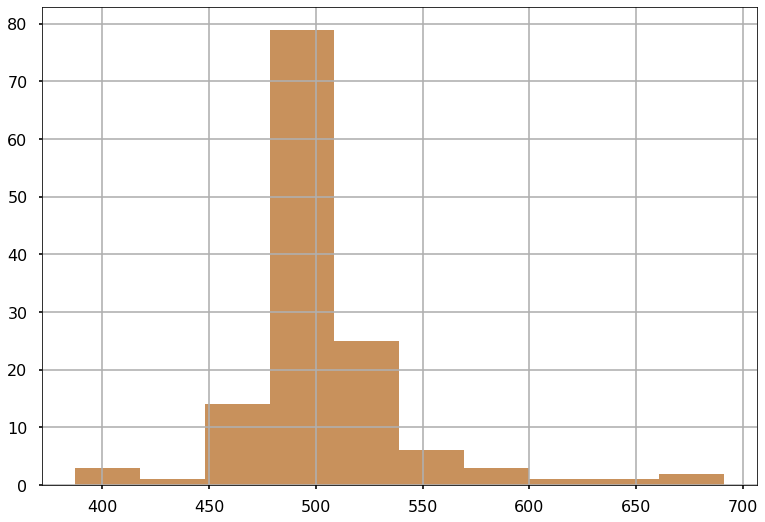

In [64]:
df['dev_score'].hist(alpha=0.6)
df_processed['dev_score'].hist(alpha=0.6)

#### Load DATA

In [65]:
with open('unprocessed_df.pkl', 'rb') as f:
    d = pkl.load(f)
d

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,nr_trans_ratio,iqt9413,dollar_val_returns_3d,nr_returns_30d,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code,borrower_id,type
0,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.160000,0.0,0.0,0.0,10298.0,0.0153,46.0,POSDW,8068974.0,regular
1,100.0,768.0,8.0,0.043,0.288,0.9952,inf,0.310000,0.406,0.9096,...,1.000000,0.0,0.0,0.0,183631.0,0.0215,4.0,ACHDDIN,8800403.0,regular
2,300.0,793.0,15.0,0.182,0.227,0.9959,-0.911184,789.780000,0.202,0.9096,...,0.285714,0.0,0.0,0.0,1805.0,0.0355,311.0,ACHDW,1511678.0,regular
3,5000.0,726.0,68.0,0.467,0.163,0.9946,0.016916,8773.400000,0.154,0.9096,...,0.666667,0.0,0.0,0.0,16298.0,0.0221,72.0,DDCK,7627983.0,regular
4,150.0,638.0,91.0,0.195,0.667,0.9525,-0.128694,318.542308,0.224,0.9096,...,0.461538,1.0,0.0,0.0,1365.0,0.0508,83.0,ACHDWIN,8234793.0,regular
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.160000,0.0,NaN,0.0,10298.0,0.0153,46.0,POSDW,8068974.0,missing
131,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.160000,0.0,0.0,NaN,10298.0,0.0153,46.0,POSDW,8068974.0,missing
132,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.160000,0.0,0.0,0.0,NaN,0.0153,46.0,POSDW,8068974.0,missing
133,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.160000,0.0,0.0,0.0,10298.0,NaN,46.0,POSDW,8068974.0,missing


In [66]:
with open('preprocessed_df.pkl', 'rb') as f:
    d = pkl.load(f)
d

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,fraud_score_1,age_money_account,transaction_code,borrower_id,type,all7120_default_encoded,bcc7120_default_encoded,transaction_code_encoded,dev_pred,dev_score
0,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.0153,46.0,POSDW,8068974.0,regular,-1.0,-1.0,1,0.011315,494.205931
1,100.0,768.0,8.0,0.043,0.288,0.9952,750.000000,0.310000,0.406,0.9096,...,0.0215,4.0,ACHDDIN,8800403.0,regular,-1.0,-1.0,4,0.015988,505.003577
2,300.0,793.0,15.0,0.182,0.227,0.9959,-0.911184,789.780000,0.202,0.9096,...,0.0355,311.0,ACHDW,1511678.0,regular,-1.0,-1.0,5,0.001939,439.559861
3,5000.0,726.0,68.0,0.467,0.163,0.9946,0.016916,8773.400000,0.154,0.9096,...,0.0221,72.0,DDCK,7627983.0,regular,-1.0,-1.0,10,0.008904,486.746068
4,150.0,638.0,91.0,0.195,0.667,0.9525,-0.128694,318.542308,0.224,0.9096,...,0.0508,83.0,ACHDWIN,8234793.0,regular,-1.0,-1.0,3,0.017755,508.288886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.0153,46.0,POSDW,8068974.0,missing,-1.0,-1.0,1,0.011315,494.205931
131,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.0153,46.0,POSDW,8068974.0,missing,-1.0,-1.0,1,0.011315,494.205931
132,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.0153,46.0,POSDW,8068974.0,missing,-1.0,-1.0,1,0.010900,493.041023
133,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,NaN,46.0,POSDW,8068974.0,missing,-1.0,-1.0,1,0.017705,508.200456


In [31]:
df

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,fraud_score_1,age_money_account,transaction_code,borrower_id,type,all7120_default_encoded,bcc7120_default_encoded,transaction_code_encoded,dev_pred,dev_score
0,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.0153,46.0,POSDW,8068974.0,regular,-1.0,-1.0,1,0.011315,494.205931
1,100.0,768.0,8.0,0.043,0.288,0.9952,750.000000,0.310000,0.406,0.9096,...,0.0215,4.0,ACHDDIN,8800403.0,regular,-1.0,-1.0,4,0.015988,505.003577
2,300.0,793.0,15.0,0.182,0.227,0.9959,-0.911184,789.780000,0.202,0.9096,...,0.0355,311.0,ACHDW,1511678.0,regular,-1.0,-1.0,5,0.001939,439.559861
3,5000.0,726.0,68.0,0.467,0.163,0.9946,0.016916,8773.400000,0.154,0.9096,...,0.0221,72.0,DDCK,7627983.0,regular,-1.0,-1.0,10,0.008904,486.746068
4,150.0,638.0,91.0,0.195,0.667,0.9525,-0.128694,318.542308,0.224,0.9096,...,0.0508,83.0,ACHDWIN,8234793.0,regular,-1.0,-1.0,3,0.017755,508.288886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.0153,46.0,POSDW,8068974.0,missing,-1.0,-1.0,1,0.011315,494.205931
111,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.0153,46.0,POSDW,8068974.0,missing,-1.0,-1.0,1,0.011315,494.205931
112,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,0.0153,46.0,POSDW,8068974.0,missing,-1.0,-1.0,1,0.010900,493.041023
113,100.0,709.0,86.0,0.113,0.190,0.9871,-0.000736,3526.250800,0.171,0.9096,...,NaN,46.0,POSDW,8068974.0,missing,-1.0,-1.0,1,0.017705,508.200456


### Load prod-data
---

In [6]:
with open('unprocessed_df_scored.pkl', 'rb') as f:
    prod_df = pkl.load(f)

In [7]:
prod_df, _ = encode_defaults(prod_df, default_values)
prod_df = preprocess(prod_df)
prod_df['dev_pred'] = model.predict_proba(prod_df[features])[:, 1]
prod_df['dev_score'] = scale_scores(prod_df['dev_pred'])

<AxesSubplot:>

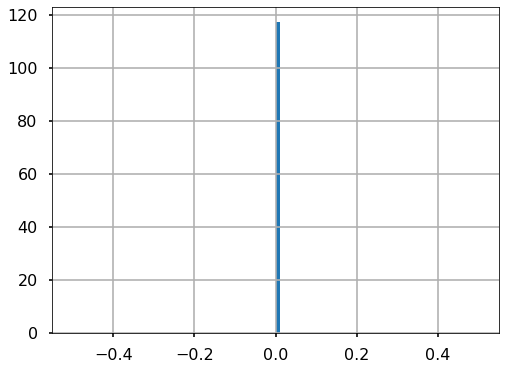

In [9]:
(prod_df.model_score - prod_df.dev_score).hist(bins=100, figsize=(8, 6))

### Generate Report
---

In [10]:
prod_df.model_score.to_frame().describe()

,model_score
count,117.000000
mean,555.435308
std,30.639587
min,444.994095
25%,549.766010
50%,552.331760
75%,560.644237
max,743.414674


In [12]:
prod_df[features]

,first_deposit_amount,vantage_score,bcc7120,email_risk_score,fraud_score_2,name_email_correlation,transaction_as_pct_of_balance,mean_account_balance_30d,phone_risk_score,name_address_correlation,...,nr_trans_ratio,iqt9413,dollar_val_returns_3d,nr_returns_30d,credit_card_loan_amount,fraud_score_1,age_money_account,transaction_code_encoded,all7120_default_encoded,bcc7120_default_encoded
0,100.0,737.0,51.0,0.172,0.514,0.9953,549.056604,291.530000,0.832,0.9096,...,1.000000,0.0,0.0,0.0,7323.0,0.0272,103.0,2,-1.0,-1.0
1,25.0,669.0,34.0,0.558,0.384,0.9953,0.021057,141.740000,0.464,0.9096,...,0.666667,0.0,0.0,0.0,101.0,0.0258,120.0,2,-1.0,-1.0
2,120.0,757.0,10.0,0.404,0.333,0.9959,750.000000,30.155000,0.190,0.9096,...,1.000000,1.0,0.0,0.0,1069.0,0.0225,1.0,2,-1.0,-1.0
3,100.0,560.0,NaN,0.157,0.303,0.9864,-1.000000,137.500000,0.627,0.9096,...,1.000000,0.0,100.0,1.0,0.0,0.0310,3.0,2,-1.0,996.0
4,25.0,704.0,98.0,0.122,0.187,0.9953,-0.040361,971.188478,0.118,0.9990,...,0.133333,0.0,0.0,0.0,8516.0,0.0232,171.0,1,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,100.0,737.0,51.0,0.172,0.514,0.9953,549.056604,291.530000,0.832,0.9096,...,1.000000,0.0,0.0,0.0,7323.0,0.0272,103.0,2,-1.0,-1.0
113,100.0,737.0,51.0,0.172,0.514,0.9953,549.056604,291.530000,0.832,0.9096,...,1.000000,0.0,0.0,0.0,7323.0,0.0272,103.0,2,-1.0,-1.0
114,100.0,737.0,51.0,0.172,0.514,0.9953,549.056604,291.530000,0.832,0.9096,...,1.000000,0.0,0.0,0.0,NaN,0.0272,103.0,2,-1.0,-1.0
115,100.0,737.0,51.0,0.172,0.514,0.9953,549.056604,291.530000,0.832,0.9096,...,1.000000,0.0,0.0,0.0,7323.0,NaN,103.0,2,-1.0,-1.0


In [23]:
# col_order = ['type', 'model_score', 'dev_score'] + features
# output_df = prod_df[col_order]
# output_df.columns = ['type', 'prod_score', 'dev_score'] + features
# output_df.loc[output_df['type']=='missing', ['type']] = "Missing value for inputs"
# output_df.loc[output_df['type']=='special_value', ['type']] = "Special value for inputs"
# output_df.loc[output_df['type']=='out_of_range', ['type']] = "Out of range"
# output_df.loc[output_df['type']=='regular', ['type']] = "Regular value"

In [30]:
with open('unprocessed_df.pkl', 'rb') as f:
    unprocessed_df = pkl.load(f)
unprocessed_df

output_df = prod_df[['model_score', 'dev_score']].merge(unprocessed_df, left_index=True, right_index=True)

In [31]:
output_df.fillna('NaN').to_csv('../../artifacts/post-implementation-testing/custom-tests/edge-case-performance.csv')

In [32]:
output_df.type.value_counts()

out_of_range     38
missing          38
special_value    29
regular          10
Name: type, dtype: int64